# Traffic Light Detection

This is a traffice light detection training proess for self driving cars, using transfer learning 

## Libraries 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
plt.style.use('ggplot')

C:\Users\livel\Miniconda3\envs\carnd-advdl-odlab\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\livel\Miniconda3\envs\carnd-advdl-odlab\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\livel\Miniconda3\envs\carnd-advdl-odlab\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\livel\Miniconda3\envs\car

## Load Pretrained Model

The model is from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

In [2]:
!pwd

/c/Users/livel/Dropbox/coding/udacity/self_driving_car/traffic_light_detection


In [4]:
PRETRAINED_MODEL_PATH = './models/model2/frozen_inference_graph.pb'
#PRETRAINED_MODEL_PATH = './models/model1/frozen_inference_graph.pb'
#PRETRAINED_MODEL_PATH = './models/transfer_ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
#PRETRAINED_MODEL_PATH = './models/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
#PRETRAINED_MODEL_PATH = './models/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'

In [5]:
# load graph
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [6]:
detection_graph = load_graph(PRETRAINED_MODEL_PATH)

In [7]:
# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [8]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)

Number of colors = 148


In [19]:
image = Image.open('./images/pat-krupa-HcWmW60sjfE-unsplash.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

[] []


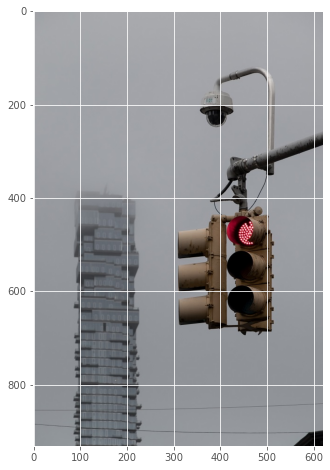

In [20]:
with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.5
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    print(classes, scores)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

In [13]:
clip = VideoFileClip('./movies/driving.mp4')

In [21]:
def pipeline(img):
    draw_img = Image.fromarray(img)
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    confidence_cutoff = 0.5
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)
    
    draw_boxes(draw_img, box_coords, classes) 
    return np.array(draw_img)


In [22]:

with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

chunk:   4%|████▍                                                                                                                        | 46/1311 [00:00<00:02, 451.91it/s, now=None]

Moviepy - Building video result.mp4.
MoviePy - Writing audio in resultTEMP_MPY_wvf_snd.mp3


t:   0%|                                                                                                                                           | 0/1782 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video result.mp4



Moviepy - Done !
Moviepy - video ready result.mp4


## Load Data for Transfer Learning

downloaded from: https://github.com/bosch-ros-pkg/bstld

### Image Data Loading

In [17]:
import glob
import os

In [18]:
train_data_path = 'C:/temp/images/bosch/rgb/train'
test_data_path = 'C:/temp/images/bosch/rgb/test'

In [19]:
train_dir_file_list = glob.glob(train_data_path+'/**', recursive=True)
train_dir_file_list = [x.replace('\\', '/') for x in train_dir_file_list if os.path.isfile(x)]
train_file_list = [os.path.basename(x) for x in train_dir_file_list if os.path.isfile(x)]
print(train_file_list)

['10648.png', '10718.png', '10786.png', '10856.png', '10926.png', '10996.png', '11064.png', '11134.png', '11204.png', '11274.png', '11342.png', '11412.png', '11482.png', '11552.png', '11620.png', '11690.png', '11760.png', '11830.png', '11898.png', '11968.png', '12038.png', '12106.png', '12176.png', '12246.png', '12316.png', '12384.png', '12454.png', '12524.png', '12594.png', '12662.png', '12732.png', '12802.png', '13122.png', '13190.png', '13260.png', '13330.png', '13398.png', '13468.png', '13538.png', '13608.png', '13676.png', '13746.png', '14262.png', '14332.png', '14400.png', '14470.png', '14540.png', '14610.png', '14678.png', '14748.png', '14818.png', '14888.png', '14956.png', '15026.png', '15096.png', '15164.png', '15234.png', '15304.png', '15374.png', '15442.png', '15512.png', '15582.png', '15652.png', '15720.png', '15790.png', '15860.png', '15930.png', '15998.png', '16068.png', '16138.png', '16208.png', '16276.png', '16346.png', '16416.png', '16484.png', '17104.png', '17174.png'

C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10648.png


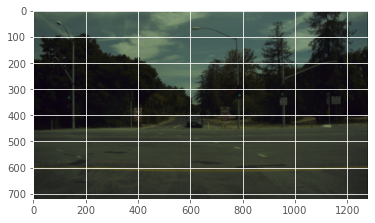

In [20]:
print(train_dir_file_list[0])
sample_image = Image.open(train_dir_file_list[0])

plt.figure()
plt.imshow(sample_image) 

In [24]:
test_dir_file_list = glob.glob(test_data_path+'/**', recursive=True)
test_dir_file_list = [x.replace('\\', '/') for x in test_dir_file_list if os.path.isfile(x)]
test_file_list = [os.path.basename(x) for x in test_dir_file_list if os.path.isfile(x)]
print(test_file_list)
print(len(test_file_list))

['26716.png', '26718.png', '26720.png', '26722.png', '26724.png', '26726.png', '26728.png', '26730.png', '26732.png', '26734.png', '26736.png', '26738.png', '26740.png', '26742.png', '26744.png', '26746.png', '26748.png', '26750.png', '26752.png', '26754.png', '26756.png', '26758.png', '26760.png', '26762.png', '26764.png', '26766.png', '26768.png', '26770.png', '26772.png', '26774.png', '26776.png', '26778.png', '26780.png', '26782.png', '26784.png', '26786.png', '26788.png', '26790.png', '26792.png', '26794.png', '26796.png', '26798.png', '26800.png', '26802.png', '26804.png', '26806.png', '26808.png', '26810.png', '26812.png', '26814.png', '26816.png', '26818.png', '26820.png', '26822.png', '26824.png', '26826.png', '26828.png', '26830.png', '26832.png', '26834.png', '26836.png', '26838.png', '26840.png', '26842.png', '26844.png', '26846.png', '26848.png', '26850.png', '26852.png', '26854.png', '26856.png', '26858.png', '26860.png', '26862.png', '26864.png', '26866.png', '26868.png'

C:/temp/images/bosch/rgb/test/26716.png


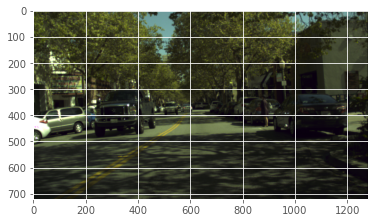

In [25]:
print(test_dir_file_list[0])
sample_image = Image.open(test_dir_file_list[0])

plt.figure()
plt.imshow(sample_image) 

In [26]:
print('train data length:', len(train_file_list))
print('test date length:', len(test_file_list))

train data length: 5093
test date length: 4152


### Label Data Loading

In [27]:
!pip install pyyaml

In [28]:
# YAML Data
import yaml

train_labels_path = 'labels/train.yaml'
test_labels_path = 'labels/test.yaml'

In [29]:
f = open(train_labels_path)
train_label = yaml.load(f)
print(train_label)

[{'boxes': [], 'path': './rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207374.png'}, {'boxes': [], 'path': './rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207384.png'}, {'boxes': [{'label': 'Yellow', 'occluded': True, 'x_max': 615.75, 'x_min': 610.625, 'y_max': 358.625, 'y_min': 351.5}, {'label': 'Yellow', 'occluded': False, 'x_max': 638.125, 'x_min': 633.875, 'y_max': 351.0, 'y_min': 342.25}, {'label': 'Yellow', 'occluded': False, 'x_max': 655.0, 'x_min': 649.5, 'y_max': 360.75, 'y_min': 350.375}], 'path': './rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207386.png'}, {'boxes': [{'label': 'RedLeft', 'occluded': True, 'x_max': 615.5, 'x_min': 612.0, 'y_max': 360.375, 'y_min': 354.75}, {'label': 'Red', 'occluded': False, 'x_max': 636.625, 'x_min': 632.25, 'y_max': 355.375, 'y_min': 346.375}, {'label': 'Red', 'occluded': False, 'x_max': 653.875, 'x_min': 649.25, 'y_max': 364.875, 'y_min': 353.5}], 'path': 

In [31]:
f = open(test_labels_path)
test_label = yaml.load(f)
print(test_label)

[{'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 752.25, 'x_min': 749.0, 'y_max': 355.125, 'y_min': 345.125}], 'path': './rgb/test/24068.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 752.625, 'x_min': 748.875, 'y_max': 354.25, 'y_min': 343.375}], 'path': './rgb/test/24070.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 753.875, 'x_min': 750.0, 'y_max': 355.625, 'y_min': 346.375}], 'path': './rgb/test/24072.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 754.5, 'x_min': 750.875, 'y_max': 359.375, 'y_min': 349.25}], 'path': './rgb/test/24074.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 754.75, 'x_min': 751.0, 'y_max': 361.875, 'y_min': 351.5}], 'path': './rgb/test/24076.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 755.625, 'x_min': 751.375, 'y_max': 363.375, 'y_min': 353.0}], 'path': './rgb/test/24078.png'}, {'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 755.5, 'x_min': 752.3

In [33]:
print('number of train labels:',len(train_label))
print('number of test labels:',len(test_label))

number of train labels: 5093
number of test labels: 8334


In [35]:
print(train_label[0])
print(train_label[5])

{'boxes': [], 'path': './rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207374.png'}
{'boxes': [{'label': 'Red', 'occluded': False, 'x_max': 640.0, 'x_min': 633.0, 'y_max': 355.625, 'y_min': 344.25}, {'label': 'RedLeft', 'occluded': True, 'x_max': 615.0, 'x_min': 610.0, 'y_max': 365.0, 'y_min': 356.5}, {'label': 'Red', 'occluded': False, 'x_max': 659.5, 'x_min': 651.875, 'y_max': 366.375, 'y_min': 353.75}], 'path': './rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/207464.png'}


### Making Dictionaries

In [50]:
train_img_dict = {x:y for x, y in zip(train_file_list, train_dir_file_list)}
train_lab_dict = {os.path.basename(x['path']):x['boxes'] for x in train_label}

In [51]:
print(train_img_dict)

{'10648.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10648.png', '10718.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10718.png', '10786.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10786.png', '10856.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10856.png', '10926.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10926.png', '10996.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10996.png', '11064.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/11064.png', '11134.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/11134.png', '11204.png': 'C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/112

In [52]:
print(train_lab_dict)

{'207374.png': [], '207384.png': [], '207386.png': [{'label': 'Yellow', 'occluded': True, 'x_max': 615.75, 'x_min': 610.625, 'y_max': 358.625, 'y_min': 351.5}, {'label': 'Yellow', 'occluded': False, 'x_max': 638.125, 'x_min': 633.875, 'y_max': 351.0, 'y_min': 342.25}, {'label': 'Yellow', 'occluded': False, 'x_max': 655.0, 'x_min': 649.5, 'y_max': 360.75, 'y_min': 350.375}], '207390.png': [{'label': 'RedLeft', 'occluded': True, 'x_max': 615.5, 'x_min': 612.0, 'y_max': 360.375, 'y_min': 354.75}, {'label': 'Red', 'occluded': False, 'x_max': 636.625, 'x_min': 632.25, 'y_max': 355.375, 'y_min': 346.375}, {'label': 'Red', 'occluded': False, 'x_max': 653.875, 'x_min': 649.25, 'y_max': 364.875, 'y_min': 353.5}], '207458.png': [{'label': 'RedLeft', 'occluded': False, 'x_max': 613.625, 'x_min': 608.875, 'y_max': 364.75, 'y_min': 354.0}, {'label': 'Red', 'occluded': False, 'x_max': 638.0, 'x_min': 633.125, 'y_max': 353.875, 'y_min': 343.375}, {'label': 'Red', 'occluded': False, 'x_max': 656.875, 

### Visual Checking of Image-Label Matching

image path: C:/temp/images/bosch/rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/11342.png
{'label': 'RedLeft', 'occluded': False, 'x_max': 118.8159394279, 'x_min': 94.5850806893, 'y_max': 302.7541861807, 'y_min': 250.5782494807}
{'label': 'RedLeft', 'occluded': False, 'x_max': 504.5818230731, 'x_min': 482.2476501092, 'y_max': 154.7141491529, 'y_min': 99.1977763569}
{'label': 'Green', 'occluded': False, 'x_max': 730.4760296222, 'x_min': 708.7799758858, 'y_max': 162.3715798833, 'y_min': 106.8552070874}
{'label': 'Green', 'occluded': False, 'x_max': 974.87569377, 'x_min': 955.0939977162, 'y_max': 282.9761138884, 'y_min': 231.9265756852}


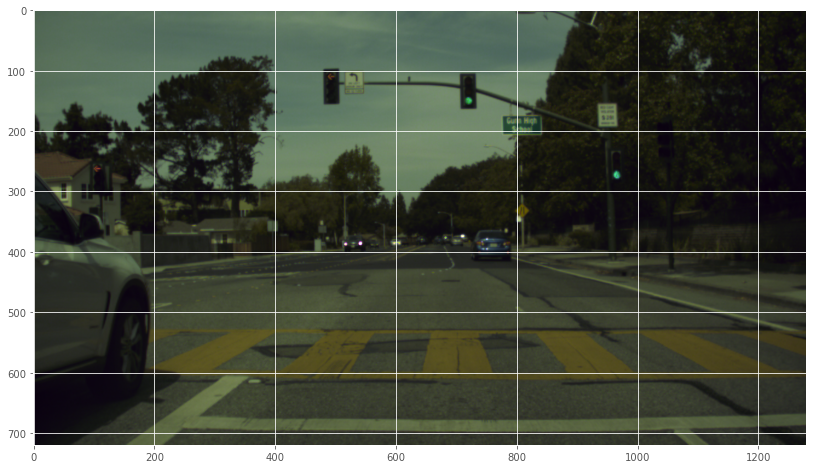

In [56]:
idx = 10 # change number to check

key = train_file_list[idx]

img_path =train_img_dict[key]

print('image path:', path)
sample_image = Image.open(img_path)

plt.figure(figsize=(20,8))
plt.imshow(sample_image) 

for item in train_lab_dict[key]:
    print(item)